In [1]:
# Warning: Execute this cell only once for the kernel. Reset the kernel if you need changes.
import sys
sys.path.append("../Python")
import ROOT as R
from array import array
import time
import numpy as np
# Turn jsroot off if you want to make a pdf from this file.
%jsroot off
from root_helpers import SetStyle
from root_helpers import fancy_plot
from root_helpers import print_mc_particle_tree
from root_helpers import print_daughters
# R.EnableImplicitMT()

Welcome to JupyROOT 6.29/01


In [2]:
import os
recompile = True
try:
    if os.path.getmtime('../Python/Utility_Functions_C.so') - os.path.getmtime('../Python/Utility_Functions.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Utility_Functions.C++")
else:
    R.gSystem.Load("../Python/Utility_Functions_C.so")
R.Utility_Functions()

Recompile is not needed


'Utility Functions V1.0.6 \n'

In [3]:
R.gSystem.Load("/data/HPS/lib/libMiniDST")
R.gSystem.Load("lib/libMC2021")
R.gInterpreter.ProcessLine('''auto EAC = Ecal_Analysis_Class();''')   # This is key. It puts the EAC in C++ space.
print(f"{R.EAC.Version()}")

V1.0.8


In [4]:
ch = R.TChain("MiniDST")
ch.Add("/data/HPS/data/MC/emumu_calchep/events_4p55GeV_000_slic_recon.root")
# ch.Add("/data/HPS/data/MC/mum_2019/mum_1_2019.root")
# ch.Add("/data/HPS/data/physrun2021/sim_2021/hpsForward_e-_3.0GeV_z0.0_*_SLIC-v06-00-01_QGSP_BERT_HPS-v2019-3pt7GeV_recon.root")
# ch.Add("/data/HPS/data/physrun2021/sim_2021/new_e-*.root")
# ch.Add("/data/HPS/data/physrun2021/pass0/minidst/hps_0147*.root")
print(f"Number of events loaded: {ch.GetEntries()/1e6:7.3f}M")

Number of events loaded:   0.005M


In [5]:
df = R.RDataFrame(ch)
dfx = R.EAC.extend_dataframe(R.RDF.AsRNode(df))
print("Available data names in Tuple:")
ColumnNames=dfx.GetColumnNames()
ll = 0
pr_colnames = [x for x in ColumnNames if str(x).startswith('')]
for nn in pr_colnames:
    if ll < len(nn):
        ll = len(nn)
for n in range(len(pr_colnames)):
    if n%4 == 0:
        print("")
    print(f"{str(pr_colnames[n]):{ll}s}",end="")

Available data names in Tuple:

ecal_cluster_energy           ecal_cluster_hits             ecal_cluster_nhits            ecal_cluster_seed_energy      
ecal_cluster_seed_index       ecal_cluster_seed_ix          ecal_cluster_seed_iy          ecal_cluster_time             
ecal_cluster_uncor_energy     ecal_cluster_uncor_hits       ecal_cluster_uncor_nhits      ecal_cluster_uncor_seed_energy
ecal_cluster_uncor_seed_index ecal_cluster_uncor_seed_ix    ecal_cluster_uncor_seed_iy    ecal_cluster_uncor_time       
ecal_cluster_uncor_x          ecal_cluster_uncor_y          ecal_cluster_uncor_z          ecal_cluster_x                
ecal_cluster_y                ecal_cluster_z                ecal_hit_energy               ecal_hit_index_x              
ecal_hit_index_y              ecal_hit_time                 ecal_hit_x                    ecal_hit_y                    
ecal_hit_z                    event_number                  ext_trigger                   hodo_cluster_energy           


In [6]:
def make_ecal_snaphot(mini_dst, hist, opt=0):
    """Return a 2D histogram for the ECal, with the energy of the hits on the z-axis"""
    if hist is None:
        hist = R.TH2D("hist_ecal","Ecal Hits",50,-25.5,24.5,13,-6.5,6.5)
    else:
        hist.Reset()
    # Fill the histogram by looping over the ECal hits
    for i in range(len(mini_dst.ecal_hit_index_x)):
        hist.Fill(mini_dst.ecal_hit_index_x[i], mini_dst.ecal_hit_index_y[i], mini_dst.ecal_hit_energy[i])
    return hist

# Setup the MiniDST class, which makes for easier event by event data inplection.
# This MiniDST class looks directly into the TTree, so does not use the RDataframe class.
# You need to:
mdst = R.MiniDst()          # Initiate the class
mdst.use_mc_particles=True  # Tell it to look for the MC Particles in the TTree
mdst.use_ecal_cluster_uncor = True
mdst.use_mc_scoring =True
mdst.DefineBranchMap()      # Define the map of all the branches to the contents of the TTree
mdst.SetBranchAddressesOnTree(ch) # Connect the TChain (which contains the TTree) to the class.
print(f"MminiDST version = {mdst._version_()}")
event = 1

MminiDST version = 1.0.9


In [7]:
event = 0
primary_index = -1
def Print_Event():
    global event, primary_index

    print(f"event = {event} Run: {mdst.run_number}, Event Num:{mdst.event_number}")
    print(f"NClusters: {len(mdst.ecal_cluster_seed_ix)} :",end="")
    for i in range(len(mdst.ecal_cluster_seed_index)):
        print(f" [{mdst.ecal_cluster_seed_index[i]}]({mdst.ecal_cluster_x[i]:7.3f},{mdst.ecal_cluster_y[i]:7.3f},{mdst.ecal_cluster_uncor_energy[i]:7.3f})", end=",")
    print("\n")
    print("   i |   x |   y |  Energy  ")
    esum=0
    print("----------------------------")
    for i in range(len(mdst.ecal_hit_index_x)):
        print(f" {i:3d} | {mdst.ecal_hit_index_x[i]:3d} | {mdst.ecal_hit_index_y[i]:3d} | {mdst.ecal_hit_energy[i]:7.5f} ")
        esum+=mdst.ecal_hit_energy[i]
    print(f"Energy sum = {esum}")
    print_mc_particle_tree(mdst)
    primary_index = -1
    for i in range(len(mdst.mc_part_z)):
        if abs(mdst.mc_part_z[i])<1e-6:
            primary_index = i
            break
    print(f"primary_index = {primary_index}")
    status = np.uintc(mdst.mc_part_sim_status[primary_index])
    print(f"Status: {status:d} = {status:033b} Decay in Cal? {status >> 26 & 1}")
    print("-------------")
    # print(mdst.ecal_hit_index_x)
    # print(mdst.ecal_hit_index_y)

In [8]:
cc2 = R.TCanvas("cc2","Canvas",900,600)
legend2 = None
hh = None
ones = None
dot_graph = None
dot2_graph = None
dot3_graph = None
dot4_graph = None
clus_dot_graph = None
clus_dot_uncor_graph = None
track_dot_graph = None
cl_idx = None


def Show_Event():
    global hh, ones, dot_graph, dot2_graph, dot3_graph, clus_dot_graph, clus_dot_uncor_graph, track_dot_graph, legend2
    global cl_idx
    global dot4_graph

    hh = make_ecal_snaphot(mdst, hh, 0)
    hh.SetStats(0)
    cc2.Clear()
    ones = fancy_plot(hh, ones, 0x0)
    pzsum = 0;
    print(f"Primary particle into scoring plane, index = {primary_index}")
    x_ave = 0
    y_ave = 0
    x_dots = array('d')
    y_dots = array('d')
    x_dots2 = array('d')
    y_dots2 = array('d')
    x_dots3 = array('d')
    y_dots3 = array('d')
    x_dots4 = array('d')
    y_dots4 = array('d')

    for i in range(len(mdst.mc_score_pdg)):
        if mdst.mc_score_z[i] > 1400 and mdst.mc_score_pz[i] > 0.01 and mdst.mc_score_part_idx[i] == primary_index :  # and mdst.mc_score_pz[i] > 2.8
            pzsum += mdst.mc_score_pz[i]
            x_ave += mdst.mc_score_x[i]*mdst.mc_score_pz[i]
            y_ave += mdst.mc_score_y[i]*mdst.mc_score_pz[i]
            print(f"[{mdst.mc_score_part_idx[i]:3d}] {mdst.mc_score_pdg[i]:3d} ({mdst.mc_score_x[i]:7.1f},{mdst.mc_score_y[i]:7.1f}) pz={mdst.mc_score_pz[i]:7.5f}")

    if pzsum == 0:
        x_ave = 0
        y_ave = 0
    else:
        x_ave = x_ave/pzsum
        y_ave = y_ave/pzsum
        x_dots.append(R.EAC.ecal_xpos_to_index(x_ave))
        y_dots.append(R.EAC.ecal_ypos_to_index(y_ave))

    print(f"Primary hits: (x,y)_ave = ({x_ave:7.1f}, {y_ave:7.1f}) Pz sum = {pzsum:7.4f}")
    print("Secondary particles:")
    for i in range(len(mdst.mc_score_pdg)):
        if mdst.mc_score_z[i] > 1400 and mdst.mc_score_pz[i] > 0.01 and mdst.mc_score_part_idx[i] != primary_index :  # and mdst.mc_score_pz[i] > 2.8
            x_dots2.append(R.EAC.ecal_xpos_to_index(mdst.mc_score_x[i]))
            y_dots2.append(R.EAC.ecal_ypos_to_index(mdst.mc_score_y[i]))
            pzsum += mdst.mc_score_pz[i]
            print(f"{len(x_dots2)-1:2d}:{i:3d} [{mdst.mc_score_part_idx[i]:3d}] {mdst.mc_score_pdg[i]:3d} ({mdst.mc_score_x[i]:7.1f},{mdst.mc_score_y[i]:7.1f}) pz={mdst.mc_score_pz[i]:7.5f}")

    print(f"Pz sum = {pzsum}")

    print("Score Clusters:")
    cl_idx = R.EAC.get_score_cluster_indexes(mdst.mc_score_pz, mdst.mc_score_x, mdst.mc_score_y, mdst.mc_score_z,
                                             mdst.ecal_cluster_x, mdst.ecal_cluster_y)
    x_aves = R.EAC.get_score_cluster_loc(cl_idx, mdst.mc_score_x, mdst.mc_score_pz)
    y_aves = R.EAC.get_score_cluster_loc(cl_idx, mdst.mc_score_y, mdst.mc_score_pz)
    pz_sums = R.EAC.get_score_cluster_pz(cl_idx, mdst.mc_score_pz)
    e_sums = R.EAC.get_score_cluster_e(cl_idx, mdst.mc_score_px, mdst.mc_score_py, mdst.mc_score_pz)
    # for i in range(len(cl_idx)):
    #     x_ave = 0
    #     y_ave = 0
    #     pzsum = 0
    #     for j in range(len(cl_idx[i])):
    #         idx = cl_idx[i][j]
    #         x_ave += mdst.mc_score_x[idx]*mdst.mc_score_pz[idx]
    #         y_ave += mdst.mc_score_y[idx]*mdst.mc_score_pz[idx]
    #         pzsum += mdst.mc_score_pz[idx]
    #
    #     x_ave = x_ave/pzsum
    #     y_ave = y_ave/pzsum
    for i in range(len(x_aves)):
        x_ave = x_aves[i]
        y_ave = y_aves[i]
        pzsum = pz_sums[i]
        print(f"i: {i:2d} N={len(cl_idx[i]):3d} ({R.EAC.ecal_xpos_to_index(x_ave):6.2f},{R.EAC.ecal_ypos_to_index(y_ave):6.2f}) ({x_ave:7.1f},{y_ave:7.1f}) pz = {pzsum:7.4f}")
        x_dots3.append(R.EAC.ecal_xpos_to_index(x_ave))
        y_dots3.append(R.EAC.ecal_ypos_to_index(y_ave))

    # Fill the individual score plane hits
    for i in range(len(mdst.mc_score_x)):
        if mdst.mc_score_pz[i] > 0.05 and mdst.mc_score_z[i] > 1440:
             x_dots4.append(R.EAC.ecal_xpos_to_index(mdst.mc_score_x[i]))
             y_dots4.append(R.EAC.ecal_ypos_to_index(mdst.mc_score_y[i]))

    x_clus_dot = array('d')
    y_clus_dot = array('d')
    x_clus_uncor_dot = array('d')
    y_clus_uncor_dot = array('d')

    for i in range(len(mdst.ecal_cluster_seed_ix)):
        print(f"Cluster: ({mdst.ecal_cluster_seed_ix[i]:3d},{mdst.ecal_cluster_seed_iy[i]:2d}) ({mdst.ecal_cluster_x[i]:6.2f},{mdst.ecal_cluster_y[i]:6.2f}) ({mdst.ecal_cluster_uncor_x[i]:6.2f}, {mdst.ecal_cluster_uncor_y[i]:6.2f}) E={mdst.ecal_cluster_uncor_energy[i]:7.4f} GeV")
        x_clus_dot.append(R.EAC.ecal_xpos_to_index(mdst.ecal_cluster_x[i]))
        y_clus_dot.append(R.EAC.ecal_ypos_to_index(mdst.ecal_cluster_y[i]))
        x_clus_uncor_dot.append(R.EAC.ecal_xpos_to_index(mdst.ecal_cluster_uncor_x[i]))
        y_clus_uncor_dot.append(R.EAC.ecal_ypos_to_index(mdst.ecal_cluster_uncor_y[i]))


    x_track = array('d')
    y_track = array('d')
    for i in range(len(mdst.track_x_at_ecal)):
        if mdst.track_type[i] == 1:
            print(f"Track:            ({mdst.track_x_at_ecal[i]:6.2f},{mdst.track_y_at_ecal[i]:6.2f},{mdst.track_z_at_ecal[i]:6.2f}) P=({mdst.track_px[i]:6.2f},{mdst.track_py[i]:6.2f},{mdst.track_pz[i]:6.2f})")
            x_track.append(R.EAC.ecal_xpos_to_index(mdst.track_x_at_ecal[i]))
            y_track.append(R.EAC.ecal_ypos_to_index(mdst.track_y_at_ecal[i]))

    legend2 = R.TLegend(0.,0.8,0.25,0.99)

    if len(x_dots)>0:
        dot_graph = R.TGraph(len(x_dots), x_dots, y_dots)
        dot_graph.SetMarkerColor(R.kRed)
        dot_graph.SetMarkerSize(1.5)
        dot_graph.SetMarkerStyle(R.kFullCircle)
        dot_graph.Draw("P")
        legend2.AddEntry(dot_graph,"Score plane primary hit")

    if len(x_dots3)>0:
        dot3_graph = R.TGraph(len(x_dots3), x_dots3, y_dots3)
        dot3_graph.SetMarkerColor(R.kOrange+2)
        dot3_graph.SetMarkerSize(1.1)
        dot3_graph.SetMarkerStyle(R.kFullCircle)
        dot3_graph.Draw("P")
        legend2.AddEntry(dot3_graph,"Score plane clusters")

    if len(x_dots2)>0:
        dot2_graph = R.TGraph(len(x_dots2), x_dots2, y_dots2)
        dot2_graph.SetMarkerColor(R.kOrange)
        dot2_graph.SetMarkerSize(0.5)
        dot2_graph.SetMarkerStyle(R.kFullCircle)
        dot2_graph.Draw("P")
        legend2.AddEntry(dot2_graph,"Score plane secondary hit")

    if len(x_dots4)>0:
        #print("Plot the ecal hits")
        dot4_graph = R.TGraph(len(x_dots4), x_dots4, y_dots4)
        dot4_graph.SetMarkerColor(R.kRed)
        dot4_graph.SetMarkerSize(0.3)
        dot4_graph.SetMarkerStyle(R.kFullCircle)
        dot4_graph.Draw("P")
        legend2.AddEntry(dot4_graph,"Score hits")


    if len(x_clus_dot)>0:
        clus_dot_graph = R.TGraph(len(x_clus_dot), x_clus_dot, y_clus_dot)
        clus_dot_graph.SetMarkerColor(R.kGreen+1)
        clus_dot_graph.SetMarkerSize(1.)
        clus_dot_graph.SetMarkerStyle(R.kFullCircle)
        clus_dot_graph.Draw("P")
        legend2.AddEntry(clus_dot_graph,"Cluster center")

    if len(x_clus_uncor_dot)>0:
        clus_dot_uncor_graph = R.TGraph(len(x_clus_uncor_dot), x_clus_uncor_dot, y_clus_uncor_dot)
        clus_dot_uncor_graph.SetMarkerColor(R.kCyan)
        clus_dot_uncor_graph.SetMarkerSize(0.9)
        clus_dot_uncor_graph.SetMarkerStyle(R.kFullCircle)
        clus_dot_uncor_graph.Draw("P")
        legend2.AddEntry(clus_dot_uncor_graph,"Cluster center uncor")

    if len(x_track)>0:
        track_dot_graph = R.TGraph(len(x_track), x_track, y_track)
        track_dot_graph.SetMarkerColor(R.kViolet)
        track_dot_graph.SetMarkerSize(.5)
        track_dot_graph.SetMarkerStyle(R.kFullCircle)
        track_dot_graph.Draw("P")
        legend2.AddEntry(track_dot_graph,"Track pos at ecal")

    legend2.Draw()
    cc2.Draw()

event = 2 Run: 1193700, Event Num:-138
NClusters: 2 : [1](159.256, 64.832,  0.183), [2](-92.735,-54.519,  0.185),

   i |   x |   y |  Energy  
----------------------------
   0 | -12 |  -3 | 0.03246 
   1 |  10 |   3 | 0.18321 
   2 | -11 |  -3 | 0.15304 
Energy sum = 0.3687085770070553
   0  pdg:   11  E:  0.527539 p = ( 0.015385,-0.004788, 0.527293)v = ( 0.00, 0.00, 0.00) end=(-188.24,-6.92,839.92)
              | 
              4  pdg:   22  E:  0.079092 p = (-0.036664,-0.001380, 0.070067)v = (-188.24,-6.92,839.92) end=(-194.96,-7.17,852.75)
                         | 
                         1  pdg:   11  E:  0.025601 p = (-0.012588, 0.000534, 0.022280)v = (-194.96,-7.17,852.75) end=( 0.00, 0.00, 0.00)
              5  pdg:   22  E:  0.310736 p = (-0.149836,-0.018388, 0.271602)v = (-194.54,-7.45,851.68) end=(-198.63,-7.95,859.11)
                         | 
                         2  pdg:  -11  E:  0.225985 p = (-0.108813,-0.010687, 0.197774)v = (-198.63,-7.95,859.11) end=(-205.

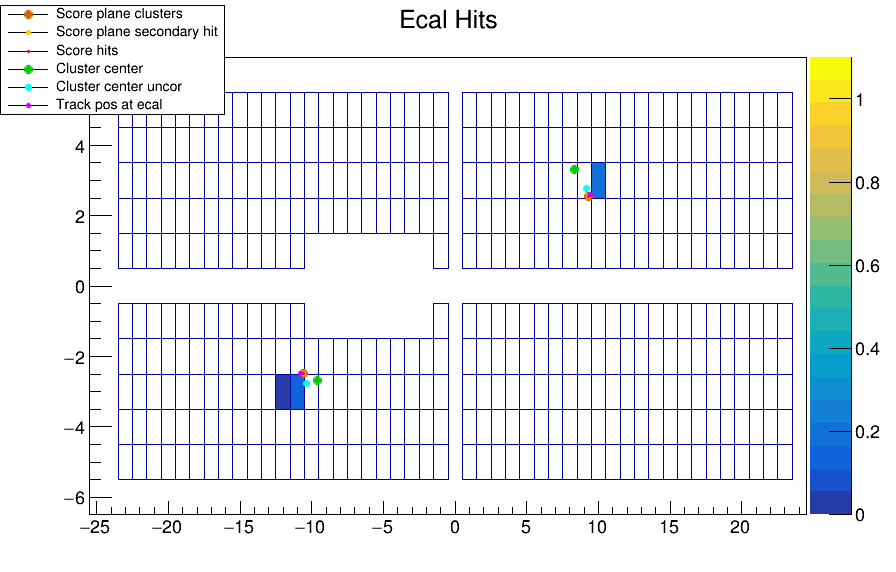

In [10]:
cluster_ncontrib = []
cluster_centers = []
cluster_ave_x = []
cluster_ave_y = []
cluster_sum_pz = []

while True:
    event+=1
    ch.GetEntry(event)

    secondary_hits_energy = R.EAC.get_score_secondary_hits_energy(mdst.mc_part_sim_status, mdst.mc_score_part_idx, mdst.mc_score_z, mdst.mc_score_px, mdst.mc_score_py, mdst.mc_score_pz)
    primary_hits_energy = R.EAC.get_score_primary_hits_energy(mdst.mc_part_sim_status, mdst.mc_score_part_idx, mdst.mc_score_z, mdst.mc_score_px, mdst.mc_score_py, mdst.mc_score_pz)

    mc_score_cluster_indexes = R.EAC.get_score_cluster_indexes(mdst.mc_score_pz,
                                                               mdst.mc_score_x, mdst.mc_score_y, mdst.mc_score_z,
                                                               mdst.ecal_cluster_x, mdst.ecal_cluster_y)
    if len(mdst.ecal_cluster_energy) >= 1:
        break

#    if len(mc_score_cluster_indexes) >= 3:
#        break
#    if len(secondary_hits_energy) > 20:
#        break
#    if count>2:
#        break
#     if len(mdst.ecal_cluster_seed_ix) >= 3:
#         break
#     if len(mdst.ecal_cluster_seed_ix) >= 1:
#         break
   # break
   #  if len(primary_hits_energy)>0 and primary_hits_energy[0]>3.2:
   #      print(f"event = {event}  E = {primary_hits_energy[0]}")
   #      break
    # if len(primary_hits_energy)>0 and primary_hits_energy[0]>3.1:
    #     print(f"event = {event}  E = {primary_hits_energy[0]}")
    #     break

    if event%1000 == 0:
        print(f"event = {event:6d}")
    if event >= ch.GetEntries():
        break

Print_Event()
Show_Event()

In [19]:
cc2.SaveAs("EcalSnapShot_many_score_clusters.pdf")

Info in <TCanvas::Print>: pdf file EcalSnapShot_many_score_clusters.pdf has been created


In [13]:
print(f"N ecal clusters: {len(mdst.ecal_cluster_x):2d}")
# R.EAC.get_score_secondary_hits_energy(mdst.mc_score_x, mdst.mc_score_part_idx, mdst.mc_score_z, mdst.mc_score_px, mdst.mc_score_py, mdst.mc_score_pz)

N ecal clusters:  2


In [21]:
primary_hits_energy

vector<double>{ 3.3477077 }

In [22]:
secondary_hits_energy

vector<double>{ 0.013125315, 0.096487720 }

In [23]:
R.EAC.get_score_n_primary_hits(mdst.mc_part_sim_status, mdst.mc_score_part_idx, mdst.mc_score_z, mdst.mc_score_pz)

vector<int>{ 5 }

In [44]:
mdst.mc_score_px[6], mdst.mc_score_py[6], mdst.mc_score_pz[6], np.sqrt(mdst.mc_score_px[6]**2 + mdst.mc_score_py[6]**2 + mdst.mc_score_pz[6]**2)

(0.5289242267608643,
 -0.08898834884166718,
 2.951568365097046,
 2.9999059281460463)

In [27]:
out = []
for i_part in range(len(mdst.mc_part_z)):
    if np.uintc(mdst.mc_part_sim_status[primary_index]) & 0x1:
        print(f"i_part = {i_part}   E = {mdst.mc_part_energy[i_part]:8.3f}  vz = {mdst.mc_part_z[i_part]:6.1f}")
        sum = 0
        for i in range(len(mdst.mc_score_part_idx)):
            if (mdst.mc_score_z[i] > 1440) and (mdst.mc_score_pz[i] > 0.01) and mdst.mc_score_part_idx[i] == i_part :
                E = np.sqrt(mdst.mc_score_px[i] * mdst.mc_score_px[i] + mdst.mc_score_py[i] * mdst.mc_score_py[i] + mdst.mc_score_pz[i] * mdst.mc_score_pz[i])
                sum += E
                print(f"i = {i} - E={E:6.3f} sum = {sum:6.3f}   p=({mdst.mc_score_px[i]:6.3f},{mdst.mc_score_py[i]:6.3f},{mdst.mc_score_pz[i]:6.3f}) "
                      f" x=({mdst.mc_score_x[i]:7.1f},{mdst.mc_score_y[i]:7.1f},{mdst.mc_score_z[i]:7.1f})")
        out.append(sum)
print(out)

i_part = 0   E =    0.013  vz = 1107.6
i = 23 - E= 0.013 sum =  0.013   p=( 0.001,-0.000, 0.013)  x=(   97.0,  -41.0, 1443.0)
i_part = 1   E =    3.000  vz =    0.0
i = 16 - E= 0.568 sum =  0.568   p=(-0.076, 0.545, 0.141)  x=(   82.3,   56.7, 1443.0)
i = 20 - E= 0.021 sum =  0.589   p=( 0.001,-0.001, 0.021)  x=(   96.8,  -41.4, 1443.0)
i = 22 - E= 1.704 sum =  2.292   p=( 0.064,-0.053, 1.702)  x=(   96.8,  -41.4, 1443.0)
i = 27 - E= 0.709 sum =  3.002   p=( 0.028,-0.020, 0.708)  x=(   96.9,  -41.3, 1443.0)
i = 28 - E= 0.346 sum =  3.348   p=( 0.211,-0.129, 0.242)  x=(  117.6,  -53.8, 1443.0)
i_part = 2   E =    0.096  vz =  909.7
i = 26 - E= 0.096 sum =  0.096   p=( 0.004,-0.003, 0.096)  x=(  100.7,  -41.3, 1443.0)
[0.013125315374536019, 3.347707724448217, 0.09648771964466923]


In [34]:
print("Summary of the score plane hits:")
sum = 0
for i in range(len(mdst.mc_score_pz)):
    if( mdst.mc_score_z[i]>1440):
        E = np.sqrt(mdst.mc_score_px[i]**2+mdst.mc_score_py[i]**2+mdst.mc_score_pz[i]**2)
        sum += E
        x = R.EAC.ecal_xpos_to_index(mdst.mc_score_x[i])
        y = R.EAC.ecal_xpos_to_index(mdst.mc_score_y[i])
        print(f"[{i:2d}] [{mdst.mc_score_part_idx[i]:3d}] pdg:{mdst.mc_score_pdg[i]}"
              f" p=({mdst.mc_score_px[i]:6.3f},{mdst.mc_score_py[i]:6.3f},{mdst.mc_score_pz[i]:6.3f})"
              f" ix=({x:8.3f},{y:8.3f})"
              f" E = {E:6.3f}")

print(f"Sum = {sum:7.4f}")

Summary of the score plane hits:
[15] [  1] pdg:11 p=(-0.000,-0.000, 0.000) ix=(   3.798,  -6.031) E =  0.000
[16] [  1] pdg:11 p=(-0.076, 0.545, 0.141) ix=(   3.163,   1.438) E =  0.568
[17] [  1] pdg:11 p=( 0.001,-0.001,-0.001) ix=(  10.562,  -9.623) E =  0.002
[18] [  2] pdg:22 p=( 0.000, 0.001,-0.000) ix=( -22.993,   7.057) E =  0.001
[19] [  1] pdg:11 p=(-0.000, 0.000,-0.000) ix=(   4.442,  -5.914) E =  0.000
[20] [  1] pdg:11 p=( 0.001,-0.001, 0.021) ix=(   4.134,  -6.146) E =  0.021
[21] [  0] pdg:22 p=(-0.001, 0.000,-0.001) ix=(   2.158,  -5.275) E =  0.001
[22] [  1] pdg:11 p=( 0.064,-0.053, 1.702) ix=(   4.134,  -6.146) E =  1.704
[23] [  0] pdg:22 p=( 0.001,-0.000, 0.013) ix=(   4.150,  -6.118) E =  0.013
[24] [  1] pdg:11 p=( 0.000, 0.000, 0.000) ix=(   8.341,  -7.362) E =  0.000
[25] [  1] pdg:11 p=( 0.000,-0.000, 0.001) ix=(   4.131,  -6.135) E =  0.001
[26] [  2] pdg:22 p=( 0.004,-0.003, 0.096) ix=(   4.395,  -6.138) E =  0.096
[27] [  1] pdg:11 p=( 0.028,-0.020, 0.708) 

In [19]:

print("--------------- Alt score cluster calc --------------")
cluster_ncontrib.clear()
cluster_centers.clear()
cluster_ave_x.clear()
cluster_ave_y.clear()
cluster_sum_pz.clear()

# Go through each mc_score hit. If not caused by primary, collect hits.
count = 0;
not_done = True
has_been_used = [False]*len(mdst.mc_score_z)
while not_done:
    # Step one: find the maximum pz

    index_max_pz = -1
    for i in range(len(mdst.mc_score_z)):
        if not has_been_used[i] and mdst.mc_score_z[i] > 1400 and mdst.mc_score_pz[i] > R.EAC.mc_score_pz_cut:
            max_pz = mdst.mc_score_pz[i]
            index_max_pz = i

    if index_max_pz < 0:
        not_done = False
    else:
        has_been_used[index_max_pz] = True
        count += 1
        x_loc = mdst.mc_score_x[index_max_pz]
        y_loc = mdst.mc_score_y[index_max_pz]
        pz_sum = mdst.mc_score_pz[index_max_pz]
        x_ave = x_loc*pz_sum
        y_ave = y_loc*pz_sum

        n_contrib = 1
        for i in range(len(mdst.mc_score_pdg)):
            if not has_been_used[i] and mdst.mc_score_z[i] > 1400 and mdst.mc_score_pz[i] > 0.03 and abs(mdst.mc_score_x[i] - x_loc) < R.EAC.mc_score_close_cut and abs(mdst.mc_score_y[i] - y_loc) < R.EAC.mc_score_close_cut:
                has_been_used[i] = True
                x_ave += mdst.mc_score_x[i]*mdst.mc_score_pz[i]
                y_ave += mdst.mc_score_y[i]*mdst.mc_score_pz[i]
                pz_sum += mdst.mc_score_pz[i]
                n_contrib += 1

        x_ave = x_ave/pz_sum
        y_ave = y_ave/pz_sum

        cluster_centers.append(index_max_pz)
        cluster_ave_x.append(x_ave)
        cluster_ave_y.append(y_ave)
        cluster_sum_pz.append(pz_sum)
        print(f"i: {count-1:2d} N = {n_contrib:3d}] idx= [{mdst.mc_score_part_idx[index_max_pz]:3d}] ({R.EAC.ecal_xpos_to_index(x_ave):6.2f},{R.EAC.ecal_ypos_to_index(y_ave):6.2f}) = ({x_ave:7.1f},{y_ave:7.1f}) pz_sum = {pz_sum:6.4f}")


--------------- Alt score cluster calc --------------
i:  0 N =   1] idx= [  0] ( 15.66,  1.80) = (  270.1,   42.0) pz_sum = 1.1339
i:  1 N =   2] idx= [  3] ( 12.40,  1.87) = (  220.5,   43.1) pz_sum = 1.7961
i:  2 N =   1] idx= [  5] ( 12.41,  1.81) = (  220.8,   42.2) pz_sum = 0.0214


In [20]:
for evt in range(ch.GetEntries()):
    if evt%10000 == 0:
        print(evt)
    ch.GetEvent(evt)
    idx = R.EAC.get_list_of_primary_mc(mdst.mc_part_sim_status)


0
10000
20000
30000


In [50]:
ch.GetEvent(110)
idx = R.EAC.get_list_of_primary_mc(mdst.mc_part_sim_status)
print(idx)
print(mdst.mc_part_energy[idx[0]])

{ 3 }
2.999999965564364


In [36]:
for evt in range(ch.GetEntries()):
    if evt%10000 == 0:
        print(evt)
    ch.GetEvent(evt)

    for i in range(len(mdst.mc_part_sim_status)):
        if ( mdst.mc_part_sim_status[i] & 0x01) == 0 and abs(mdst.mc_part_z[i]) < 1e-6:
            print(f"{np.uint(mdst.mc_part_sim_status[i]):064b}  {mdst.mc_part_z[i]}")

0
10000
20000
30000


In [51]:
for i in range(len(mdst.mc_score_type)):
    print(f"{mdst.mc_score_type[i]} {mdst.mc_score_z[i]:8.3f}")

0  111.969
0  513.472
0  312.667
0   61.811
0  212.305
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
1 1443.001
